# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

### Notes
Starting from the basin B it is possible to escape from the local minima within 5ns  
While starting from basin A it is possible to escape within 155 ns

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':340, 
    'beta': 1./(340*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :30,
}
#--------------------------------------#
print(kb*340)

2.82676


# Prepare input files for plumed

In [3]:
# arguments for deep tica cvs
ARG = ""
count =0
descriptors_file = "plumed-descriptors.dat" # "plumed-descriptors.dat", "plumed-driver.dat"
file = open('script/'+descriptors_file, 'r').readlines() # all descriptors
#file = open('script/plumed-descriptors.dat', 'r').readlines() # most important descriptors from Luigi's article, it is not correct a priori
for line in file:
    if count > 6:
        #print(line)
        if line == "\n":
            break
        ARG+=line.split()[0][:-1]
        ARG+=","
    count+=1

Time = 10
STRIDE = 100
BARRIER=40

In [4]:
# start with unbias simulation
folder = "unbias/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)
# write plumed input file for unbias simulation
with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

UNITS LENGTH=nm

MOLINFO MOLTYPE=protein STRUCTURE=chignolin-ref.pdb
WHOLEMOLECULES ENTITY0=1-166

# Define CVs

# Select Calpha
PROTEIN: GROUP ATOMS=1-166
CA: GROUP ATOMS=5,26,47,61,73,88,102,109,123,147
# RMSD
rmsd_ca: RMSD REFERENCE=chignolin-ca.pdb TYPE=OPTIMAL
# END-TO-END DISTANCE
end: DISTANCE ATOMS=5,147
# HBONDS
hbonds: CONTACTMAP ATOMS1=23,145 ATOMS2=45,120 ATOMS3=56,100 ATOMS4=56,107 SWITCH={RATIONAL R_0=0.4 NN=6 MM=8} SUM
ene: ENERGY

INCLUDE FILE="""+descriptors_file+"""

# define cv
deep0: PYTORCH_MODEL FILE=../deeptica/model.ptc ARG="""+ARG+"""

opes: OPES_METAD ARG=deep0.node-0,deep0.node-1 TEMP="""+str(sim_parameters["temp"])+""" PACE=500 BIASFACTOR=5 RESTART=NO FILE=KERNELS BARRIER="""+str(BARRIER)+""" STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10  

PRINT FMT=%g STRIDE="""+str(STRIDE)+""" FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

print("###--- Start Simulations ---###")
#-- run gromacs --#
execute("cp script/* "+folder,folder=".")
execute("sed -i '0,/ns/s/ns.*/ns="+str(Time)+"/' run_gromacs.sh",folder=folder)
#execute("./run_gromacs.sh",folder=folder)

###--- Start Simulations ---###
Completed: cp script/* unbias/bias1/
Completed: sed -i '0,/ns/s/ns.*/ns=10/' run_gromacs.sh


True

## Analysis

In [5]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^dd_[^a-z]').columns.values

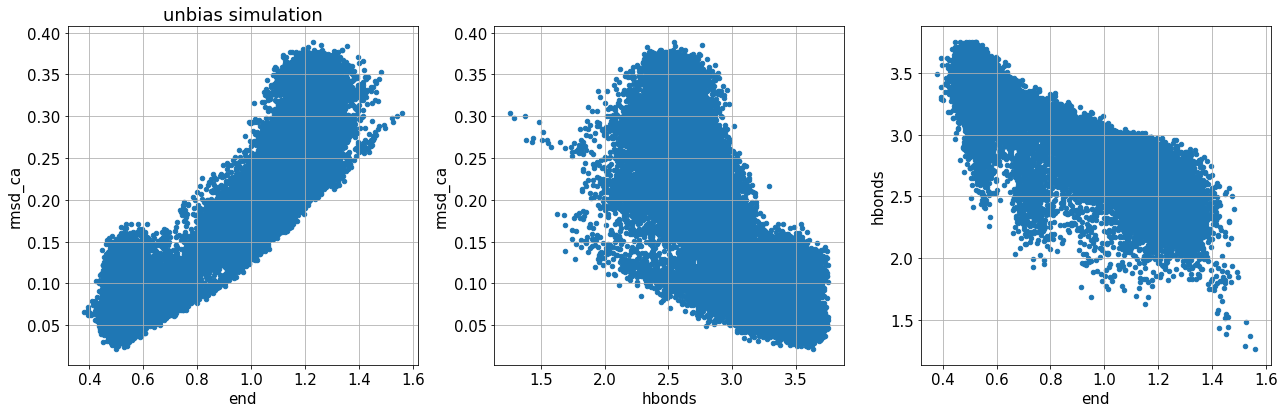

In [6]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
    
#rmsd_ca end hbonds
data.plot.scatter(y="rmsd_ca",x="end",ax=axs[0])
axs[0].grid()
axs[0].set_title("unbias simulation")
axs[0].set_ylabel("rmsd_ca")
axs[0].set_xlabel("end")

data.plot.scatter(y="rmsd_ca",x="hbonds",ax=axs[1])
axs[1].grid()
axs[1].set_ylabel("rmsd_ca")
axs[1].set_xlabel("hbonds")

data.plot.scatter(y="hbonds",x="end",ax=axs[2])
axs[2].grid()
axs[2].set_ylabel("hbonds")
axs[2].set_xlabel("end")

plt.tight_layout()

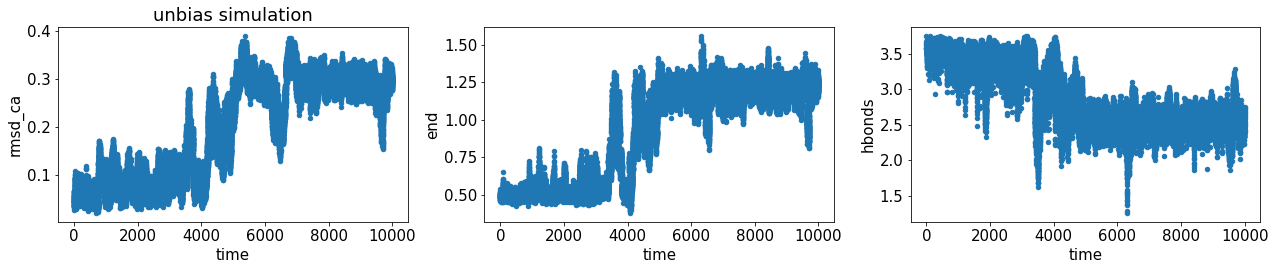

In [7]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
data.plot.scatter(x="time",y="rmsd_ca",ax=axs[0])
data.plot.scatter(x="time",y="end",ax=axs[1])
data.plot.scatter(x="time",y="hbonds",ax=axs[2])

axs[0].set_title("unbias simulation")
plt.tight_layout()

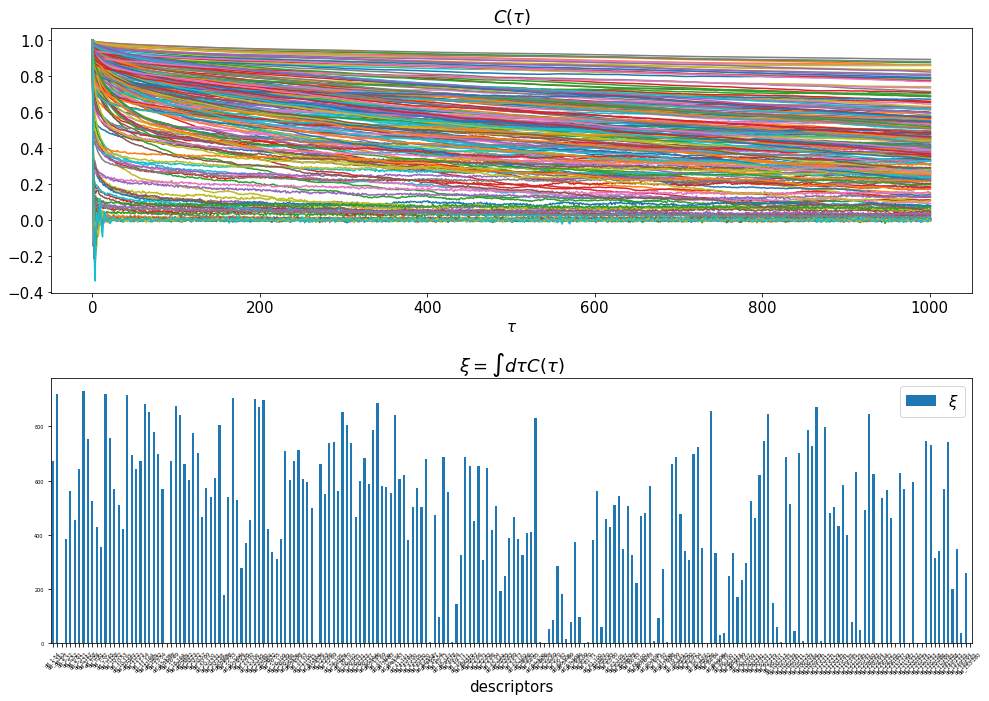

930.818642888554
0.5824864698726174


In [8]:
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=1000
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    #print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=45,ax=axs[1],fontsize=5,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#fit_timeacorr(descriptors_names,data,axs=None)

## DeepTICA Analysis and Export

In [9]:
min_lag,max_lag = 0.2,5 
n = 5 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^dd[^a-z]').columns.values

#-- TRAINING PARAMETERS --#
n_output = 5 # 2 non linear combination of the descriptors  
n_input = len(descriptors_names) # can change..
train_parameters = {
              'descriptors': '^dd[^a-z]', # can change during simulation
              'nodes':[n_input,60,30,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':600,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }

# how many data in single batch, batchsize
n_train = int( len(data)*train_parameters["trainsize"] )
n_valid = int( len(data)*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values

[0.2 1.4 2.6 3.8 5. ]
training samples:  35000 	 validation samples 14950


In [10]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -4.553      -4.538      0.960  0.938  0.899  0.832  0.793  
100   -4.818      -4.805      0.982  0.973  0.956  0.928  0.918  
150   -4.892      -4.874      0.989  0.984  0.974  0.957  0.948  
INFO: Early stopping
191   -4.919      -4.897      0.991  0.987  0.981  0.967  0.960  
already exists


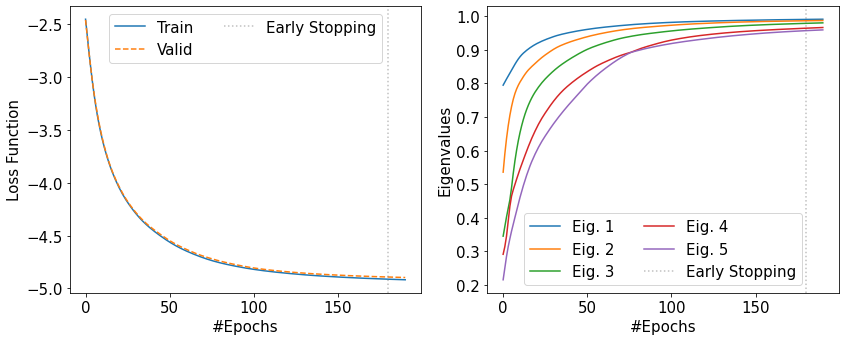

In [11]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [12]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

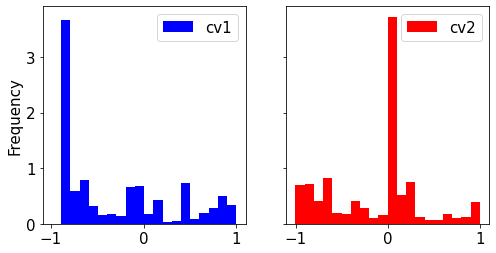

In [13]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

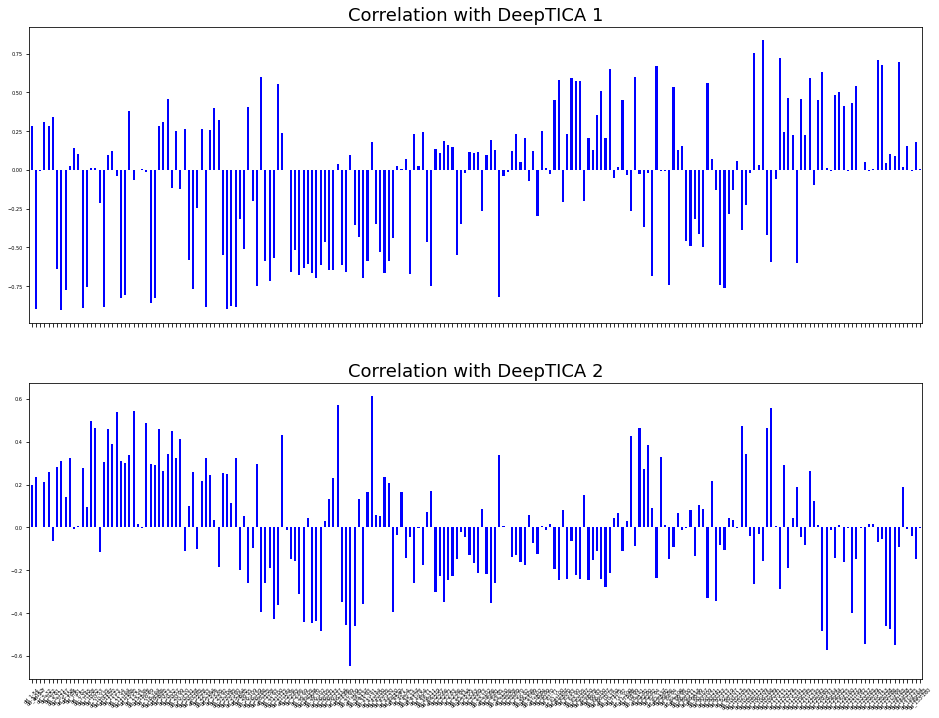

In [14]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=45, color="b",fontsize=5,label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

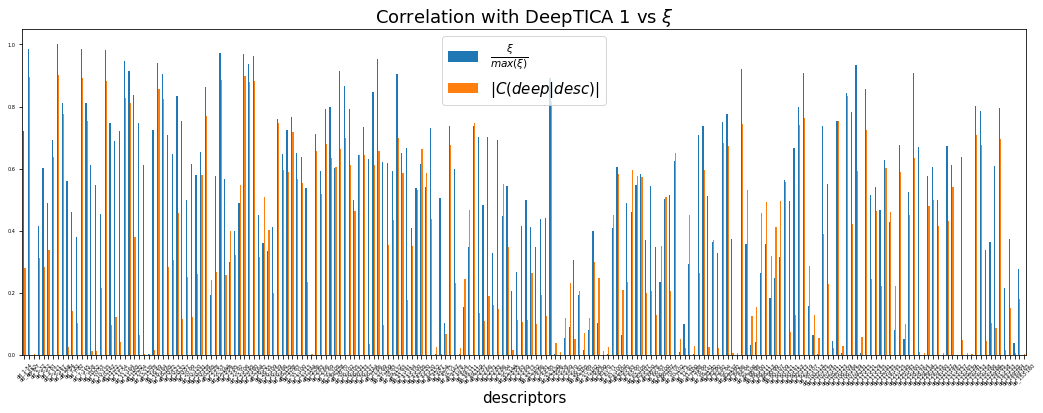

In [15]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=45,ax=ax,fontsize=5,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


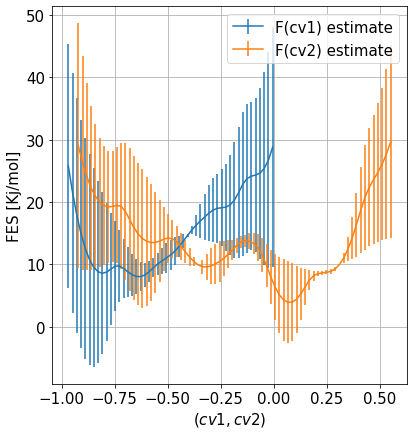

In [16]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=data["opes.bias"].to_numpy()*sim_parameters["beta"]

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

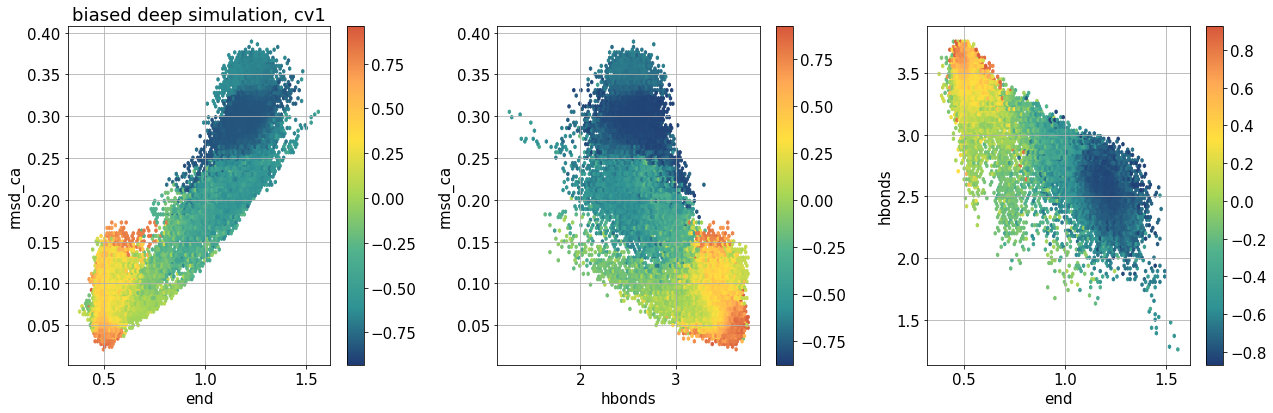

In [17]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
    
#rmsd_ca end hbonds
data.plot.hexbin(y="rmsd_ca",x="end",C="cv1",cmap="fessa",ax=axs[0])
axs[0].grid()
axs[0].set_title("biased deep simulation, cv1")
axs[0].set_ylabel("rmsd_ca")
axs[0].set_xlabel("end")

data.plot.hexbin(y="rmsd_ca",x="hbonds",C="cv1",cmap="fessa",ax=axs[1])
axs[1].grid()
axs[1].set_ylabel("rmsd_ca")
axs[1].set_xlabel("hbonds")

data.plot.hexbin(y="hbonds",x="end",C="cv1",cmap="fessa",ax=axs[2])
axs[2].grid()
axs[2].set_ylabel("hbonds")
axs[2].set_xlabel("end")

plt.tight_layout()

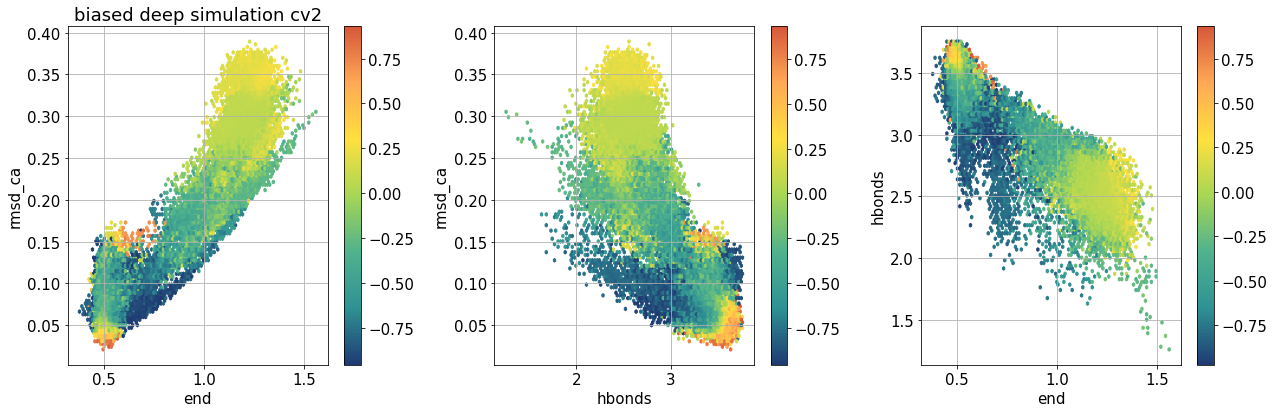

In [18]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
    
#rmsd_ca end hbonds
data.plot.hexbin(y="rmsd_ca",x="end",C="cv2",cmap="fessa",ax=axs[0])
axs[0].grid()
axs[0].set_title("biased deep simulation cv2")
axs[0].set_ylabel("rmsd_ca")
axs[0].set_xlabel("end")

data.plot.hexbin(y="rmsd_ca",x="hbonds",C="cv2",cmap="fessa",ax=axs[1])
axs[1].grid()
axs[1].set_ylabel("rmsd_ca")
axs[1].set_xlabel("hbonds")

data.plot.hexbin(y="hbonds",x="end",C="cv2",cmap="fessa",ax=axs[2])
axs[2].grid()
axs[2].set_ylabel("hbonds")
axs[2].set_xlabel("end")

plt.tight_layout()

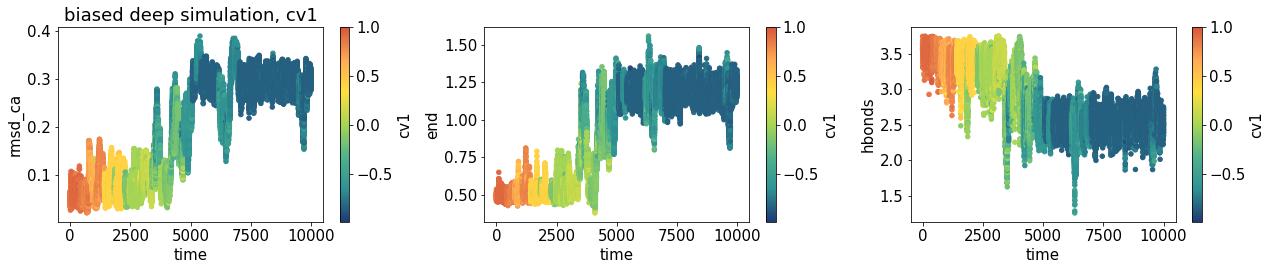

In [19]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
data.plot.scatter(x="time",y="rmsd_ca",c="cv1",cmap="fessa",ax=axs[0])
data.plot.scatter(x="time",y="end",c="cv1",cmap="fessa",ax=axs[1])
data.plot.scatter(x="time",y="hbonds",c="cv1",cmap="fessa",ax=axs[2])

axs[0].set_title("biased deep simulation, cv1")
plt.tight_layout()

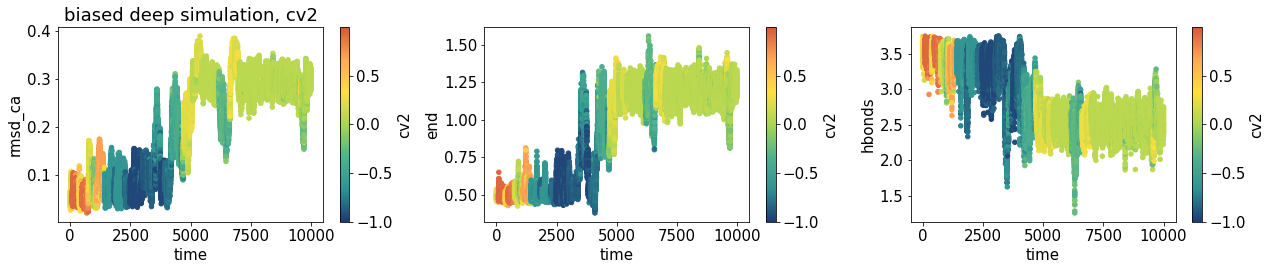

In [20]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
data.plot.scatter(x="time",y="rmsd_ca",c="cv2",cmap="fessa",ax=axs[0])
data.plot.scatter(x="time",y="end",c="cv2",cmap="fessa",ax=axs[1])
data.plot.scatter(x="time",y="hbonds",c="cv2",cmap="fessa",ax=axs[2])

axs[0].set_title("biased deep simulation, cv2")
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [21]:
Boltzmann_product(model,model,X,j=0,k=1)

0.034902039734423795

# TICA

In [22]:
# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)
#tica.tica.symmetrize = False
t = data['time'].values[::1]
X = data[descriptors_names].values[::1]

In [23]:
# TRAIN
#tica.tica.reg_cholesky=0.000000035
tica.fit(X, t, lag=1)

tica.to("cpu")
feature_names = data[descriptors_names].columns.values
tica.set_params({"feature_names": feature_names})
#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
#print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

#print(tica.plumed_input().splitlines()[:2])
#print(tica.plumed_input().splitlines()[0][8:])

In [24]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[1] 

<AxesSubplot:ylabel='Frequency'>

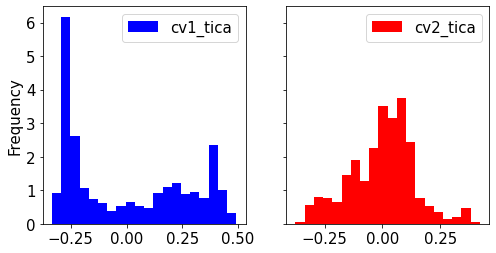

In [25]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2_tica",bins=20,ax=axs[1],density=True,color="r")

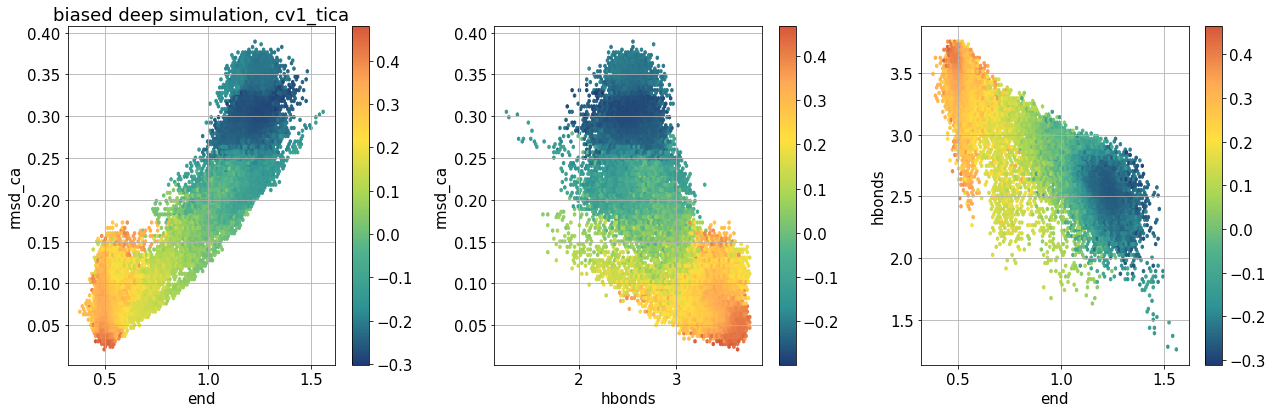

In [26]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
    
#rmsd_ca end hbonds
data.plot.hexbin(y="rmsd_ca",x="end",C="cv1_tica",cmap="fessa",ax=axs[0])
axs[0].grid()
axs[0].set_title("biased deep simulation, cv1_tica")
axs[0].set_ylabel("rmsd_ca")
axs[0].set_xlabel("end")

data.plot.hexbin(y="rmsd_ca",x="hbonds",C="cv1_tica",cmap="fessa",ax=axs[1])
axs[1].grid()
axs[1].set_ylabel("rmsd_ca")
axs[1].set_xlabel("hbonds")

data.plot.hexbin(y="hbonds",x="end",C="cv1_tica",cmap="fessa",ax=axs[2])
axs[2].grid()
axs[2].set_ylabel("hbonds")
axs[2].set_xlabel("end")

plt.tight_layout()

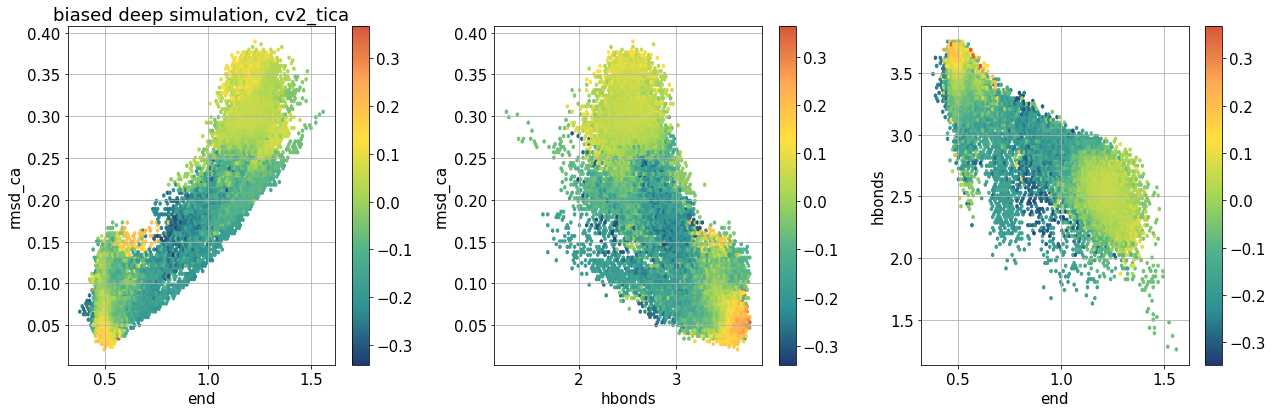

In [27]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
    
#rmsd_ca end hbonds
data.plot.hexbin(y="rmsd_ca",x="end",C="cv2_tica",cmap="fessa",ax=axs[0])
axs[0].grid()
axs[0].set_title("biased deep simulation, cv2_tica")
axs[0].set_ylabel("rmsd_ca")
axs[0].set_xlabel("end")

data.plot.hexbin(y="rmsd_ca",x="hbonds",C="cv2_tica",cmap="fessa",ax=axs[1])
axs[1].grid()
axs[1].set_ylabel("rmsd_ca")
axs[1].set_xlabel("hbonds")

data.plot.hexbin(y="hbonds",x="end",C="cv2_tica",cmap="fessa",ax=axs[2])
axs[2].grid()
axs[2].set_ylabel("hbonds")
axs[2].set_xlabel("end")

plt.tight_layout()

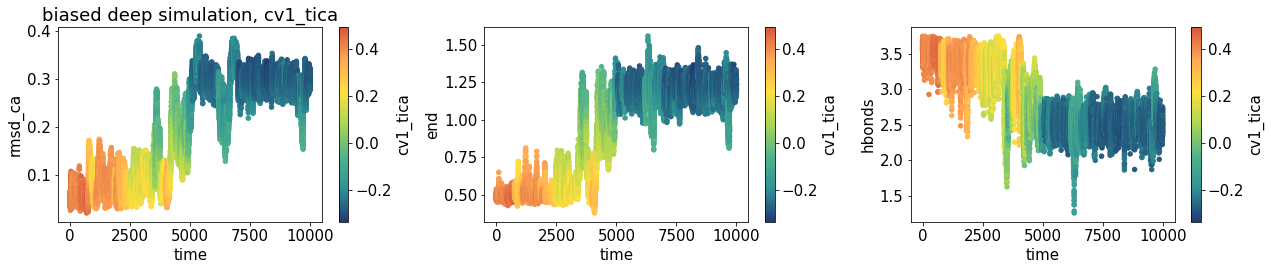

In [28]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
data.plot.scatter(x="time",y="rmsd_ca",c="cv1_tica",cmap="fessa",ax=axs[0])
data.plot.scatter(x="time",y="end",c="cv1_tica",cmap="fessa",ax=axs[1])
data.plot.scatter(x="time",y="hbonds",c="cv1_tica",cmap="fessa",ax=axs[2])

axs[0].set_title("biased deep simulation, cv1_tica")
plt.tight_layout()

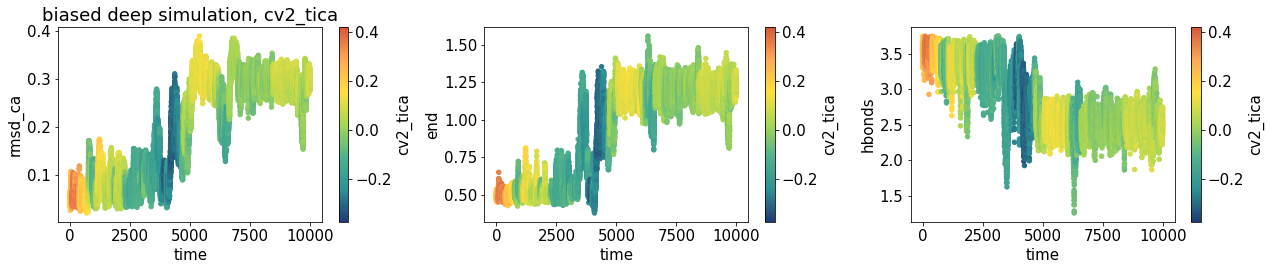

In [29]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
data.plot.scatter(x="time",y="rmsd_ca",c="cv2_tica",cmap="fessa",ax=axs[0])
data.plot.scatter(x="time",y="end",c="cv2_tica",cmap="fessa",ax=axs[1])
data.plot.scatter(x="time",y="hbonds",c="cv2_tica",cmap="fessa",ax=axs[2])

axs[0].set_title("biased deep simulation, cv2_tica")
plt.tight_layout()

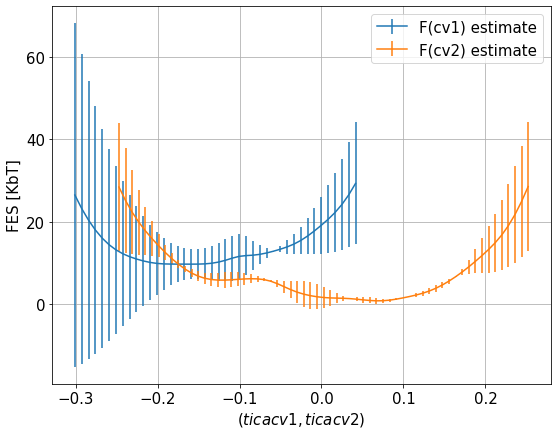

In [30]:
#-- estimation of Free Energy Surface --#
s = data[["cv1_tica","cv2_tica"]].to_numpy()
logweight=data["opes.bias"].to_numpy()*sim_parameters["beta"]

fig, ax = plt.subplots(figsize=(8,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp = sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(tica cv1,tica cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()